# Google Cloud - Retail Search API Quick Start

With Retail Search, retailers can implement Google-quality search that is customizable and built upon Google's understanding of user intent and context.

### Install the libraries used in this tutorial

In [ ]:
pip install --upgrade --user google-cloud-retail

In [ ]:
pip install --upgrade google-auth

In [ ]:
pip install --upgrade --user protobuf

### Global project variables and credentials

In [27]:
#Project Settings
project_id='pod-fr-retail'
project_number='486742359899'
credentials,project = google.auth.default(quota_project_id=project_id)

#Catalog branch represents the version of your catalog
branch= 'projects/{}/locations/global/catalogs/default_catalog/branches/1'.format(project_number)

# Catalog placement represents the search configs you're using on this catalog
placement= 'projects/{}/locations/global/catalogs/default_catalog/placements/default_search'.format(project_id)

#We are going to manage a product in our catalog
product_id=16684
product_name = client.product_path(project_number,'global','default_catalog',1,product_id)


### Get started with a simple query

Let's start by creating a search request. We instanciate a client (SearchServiceClient) and set the required field to have some product results from Retail Search 

In [29]:
from google.cloud.retail_v2.services.search_service import SearchServiceClient
from google.cloud.retail_v2.types.search_service import SearchRequest
from google.cloud.retail_v2 import Product

from typing import List, Dict, Sequence, Any

#Client
client = SearchServiceClient(credentials=credentials)

#Query Specs
search_request = SearchRequest()
search_request.query = 'shirt'
search_request.visitor_id = "123"
search_request.placement = placement
search_request.branch= branch

#Query and print results
response = client.search(search_request)
print(response.results[3])

id: "16055"
product {
  name: "projects/486742359899/locations/global/catalogs/default_catalog/branches/1/products/16055"
  categories: "Men > Clothing > Tops & Tees"
  title: "Diesel Men\'s Siranella-S Shirt"
  brands: "Diesel"
  attributes {
    key: "estimatedDeliveryDay"
    value {
      numbers: 4.0
      searchable: false
      indexable: true
    }
  }
  price_info {
    currency_code: "USD"
    price: 128.0
    original_price: 128.0
    cost: 77.05599975585938
  }
  uri: "https://retail-demo.mystorefront.org/product/16055"
  images {
    uri: "https://storage.googleapis.com/css-retail-images/subcat_tops_tees.png"
    height: 356
    width: 352
  }
  color_info {
    colors: "RED"
  }
  sizes: "XXL"
}



### Request Search Facets

Let's have a look at filters and faceting capabilities. Facets are filters you usually see on the left or right side of a search results page.
> <b> Documentation https://cloud.google.com/retail/docs/reference/rest/v2/FacetSpec

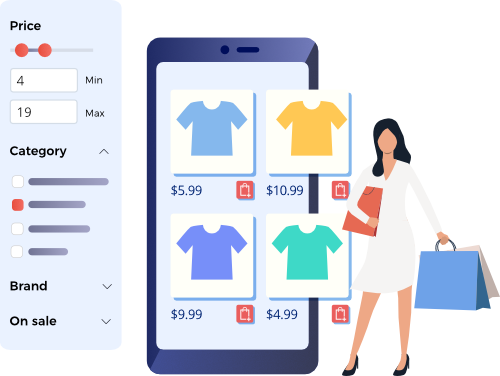

In [5]:
from IPython import display
display.Image("https://www.prefixbox.com/blog/wp-content/uploads/2020/07/Featured_image-Faceted_Search-500px-LE.png"
              ,height=200)

In [6]:
from google.cloud.retail_v2.services.search_service import SearchServiceClient
from google.cloud.retail_v2.types.search_service import SearchRequest

#Declare a Client
client = SearchServiceClient(credentials=credentials)

#Define Query Specs and Facets spec
search_request = SearchRequest()
search_request.query = 'shirt'
search_request.visitor_id = "123"
search_request.placement = placement
search_request.branch=branch
search_request.filter = "categories: ANY(\"Men > Active > Active\")"
search_request.facet_specs= [
        { 
            'facet_key': { 
                'key': 'categories' 
                }
                ,'excluded_filter_keys': ["categories"] #still show all categories' values for "categories" facet
            }
            ,{ 'facet_key': {
                'key': 'availability'
                }
             }
        ]
#Query
response = client.search(search_request)
print(response.facets[1])

key: "availability"
values {
  value: "IN_STOCK"
  count: 141
}



You can create intervals facets for a numeric facet key

In [7]:
search_request.facet_specs = [{
    'facet_key': {
        'key':
            'price',
        'intervals': [{
            'exclusive_maximum': 100.0
        }, {
            'minimum': 0.0,
            'maximum': 2.0
        }, {
            'minimum': 0.0,
            'maximum': 6.0
        }, {
            'minimum': 2.0,
            'maximum': 6.0
        }, {
            'minimum': 6.0,
            'maximum': 30.0
        }, {
            'exclusive_minimum': 2.0
        }]
    }
}]
response = client.search(search_request)

print((response.facets[0:1]))

[key: "price"
values {
  interval {
    exclusive_maximum: 100.0
  }
  count: 137
}
values {
  interval {
    minimum: 6.0
    maximum: 30.0
  }
  count: 74
}
values {
  interval {
    exclusive_minimum: 2.0
  }
  count: 141
}
]


### Product Catalog Local Inventories

We are now going to dive into Local inventories. How to set and query these local inventory.
> Documentation https://cloud.google.com/retail/docs/local-inventory-updates
#### Let's start with setting a local inventory for product id 16684 and for store789

In [33]:
from google.cloud import retail_v2

# Create a client
client = retail_v2.ProductServiceClient(credentials=credentials)

# Initialize request argument(s)
request = retail_v2.AddLocalInventoriesRequest(
    product=product_name,
    local_inventories= [ 
        retail_v2.LocalInventory( 
            place_id= 'store789'
            , price_info= retail_v2.PriceInfo(
                currency_code= 'USD',
                price = 1.21,
                original_price=1.26
            ))
    ]
)

# Make the request
operation = client.add_local_inventories(request=request, timeout=200)
import time

from IPython.display import display, clear_output
running="Waiting for operation to complete ("
i=0
while operation.running():
    i=i+1
    clear_output(wait=True)
    display(running+str(i)+" seconds)")
    time.sleep(1)
if operation.done():
    clear_output(wait=False)
    display("Done!")

'Done!'

#### We can now retieve a specific price for product 16684 in the store789 in variant_rollup_values key.

In [40]:
#Client
client = SearchServiceClient(credentials=credentials)

#Query Specs
search_request = SearchRequest()
search_request.query = 'shirt'
search_request.visitor_id = "123"
search_request.placement = placement
search_request.branch=branch
search_request.variant_rollup_keys= ["inventory(store789,price)"] #https://cloud.google.com/retail/docs/reference/rest/v2alpha/projects.locations.catalogs.placements/search#request-body
#Query
response = client.search(search_request)
print(response.results[0].variant_rollup_values["inventory(store789,price)"])

list_value {
  values {
    number_value: 1.21
  }
}



### Navigate in Query Results next page

In [54]:
#Query Results
from  google.cloud.retail_v2.services.search_service.pagers import SearchPager
search_request.page_token=response.next_page_token
response= client.search(search_request)
#next_page_results = SearchPager(response, search_request, response  )
print(response.results[0])

id: "18482"
product {
  name: "projects/486742359899/locations/global/catalogs/default_catalog/branches/1/products/18482"
  categories: "Men > Active > Active"
  title: "ExOfficio Men\'s BugsAway Halo Long Sleeve Shirt"
  brands: "ExOfficio"
  attributes {
    key: "estimatedDeliveryDay"
    value {
      numbers: 4
      searchable: false
      indexable: true
    }
  }
  price_info {
    currency_code: "USD"
    price: 99
    original_price: 99
    cost: 41.382
  }
  uri: "https://retail-demo.mystorefront.org/product/18482"
  images {
    uri: "https://storage.googleapis.com/css-retail-images/subcat_active.png"
    height: 200
    width: 146
  }
  color_info {
    colors: "RED"
  }
  sizes: "XXL"
}



## Manage Product Catalog

#### Get a product from our catalog

In [18]:

from google.cloud import retail_v2
# Create a client
client = retail_v2.ProductServiceClient(credentials=credentials)
#client.update_product('projects/486742359899/locations/global/catalogs/default_catalog/branches/1/products/16684')
product= client.get_product(name=product_name)
print(product)

name: "projects/486742359899/locations/global/catalogs/default_catalog/branches/1/products/16684"
id: "16684"
type_: PRIMARY
primary_product_id: "16684"
gtin: "123456456123"
categories: "Men > Clothing > Tops & Tees"
title: "Diesel Men\'s Stombol-S Shirt"
brands: "Diesel"
language_code: "en-US"
attributes {
  key: "estimatedDeliveryDay"
  value {
    numbers: 4.0
  }
}
price_info {
  currency_code: "USD"
  price: 98.0
  original_price: 98.0
  cost: 56.64400100708008
  price_range {
  }
}
availability: IN_STOCK
available_quantity {
  value: 10
}
fulfillment_info {
  type_: "custom-type-1"
  place_ids: "10"
}
uri: "https://retail-demo.mystorefront.org/product/16684"
images {
  uri: "https://storage.googleapis.com/css-retail-images/tops_tees-07.png"
  height: 2000
  width: 2000
}
audience {
  genders: "male"
}
color_info {
  colors: "RED"
}
sizes: "XXL"
conditions: "new"
retrievable_fields {
  paths: "title"
  paths: "categories"
  paths: "brands"
  paths: "attributes.estimated_delivery_d

#### Make a product's field available in search results 

In [26]:
product = client.get_product(name=product_name)
product.retrievable_fields.paths.append('rating')
#print(product.retrievable_fields.paths)
request = retail_v2.UpdateProductRequest(
    product=product,
)
print(product.retrievable_fields)

# Make the request
#response = client.update_product(request=request)

# Handle the response
#print(response)

paths: "title"
paths: "categories"
paths: "brands"
paths: "attributes.estimated_delivery_day"
paths: "price_info"
paths: "uri"
paths: "images"
paths: "color_info"
paths: "sizes"
paths: "rating"
paths: "rating"
paths: "rating"



#### Update gtin attribute

In [23]:
product.gtin="12345645613"
request = retail_v2.UpdateProductRequest(
    product=product,
)
response = client.update_product(request=request)
product = client.get_product(name=product_name)
print(product.gtin)

12345645613
